In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from santa import tree_packing

from santa import optimizers

/home/bamedeo/Desktop/kaggle/santa2025/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
NUM_TREES = 32
RNG = jax.random.PRNGKey(42)

In [4]:
problem = tree_packing.create_tree_packing_problem(NUM_TREES)

In [5]:
solution = tree_packing.init_solution(NUM_TREES, RNG, length=2)
solution = problem.eval(solution)
print(f"Solution-reg: {solution.reg()}")

small_noise = optimizers.noise.BisectionNoiseOptimizer(noise_level=0.01, n_steps=2)
noise = optimizers.noise.BisectionNoiseOptimizer(noise_level=0.1, n_steps=2)

opt = optimizers.alns.AdaptiveLargeNeighborhoodSearch(
    [optimizers.ruin.RandomRuin(n_remove=1), ],
    [optimizers.recreate.RandomRecreate(max_recreate=1)],
    [noise, small_noise],
)

opt = optimizers.sa.SimulatedAnnealing(
    opt,
    initial_temp=1e6,
    cooling_rate=0.99995,
    patience=100_000
)
opt = optimizers.combine.RestoreBest(opt, patience=10_000)

opt.set_problem(problem)
opt_state = opt.init_state(solution)
global_state = problem.init_global_state(seed=42)


@jax.jit
def iterations(sol, opt_state, global_state):
    def one_iteration(carry, _):
        sol, opt_state, global_state = carry
        sol, opt_state, global_state = opt.step(sol, opt_state, global_state)
        global_state = global_state.next()
        carry = sol, opt_state, global_state
        return carry, _

    carry = sol, opt_state, global_state
    (sol, opt_state, global_state), _ = jax.lax.scan(one_iteration, carry, length=1_000)
    return sol, opt_state, global_state


flops = iterations.lower(solution, opt_state, global_state).compile().cost_analysis()["flops"]
print(f"Flops: {int(flops)}")

history = {"opt_state": [opt_state], "global_state": [global_state]}
solutions = [solution]
trange = tqdm(range(500))
for it in trange:
    solution, opt_state, global_state = iterations(solution, opt_state, global_state)
    temp = opt_state.get('temperature', 0.0)
    trange.set_description(f"{global_state.best_feasible_score:.4f} - {solution.objective:.4f}"
                           f"| since={global_state.iters_since_last_improvement:6d}"
                           f"| temp={temp:.2f}")
    solutions.append(solution)
    history["opt_state"].append(opt_state)
    history["global_state"].append(global_state)

Solution-reg: 1.937915325164795
Flops: 60141


0.4892 - 0.4892| since=    52| temp=0.00: 100%|██████████| 500/500 [00:34<00:00, 14.39it/s]    


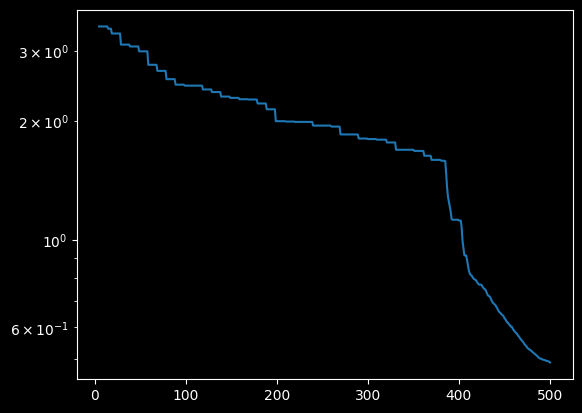

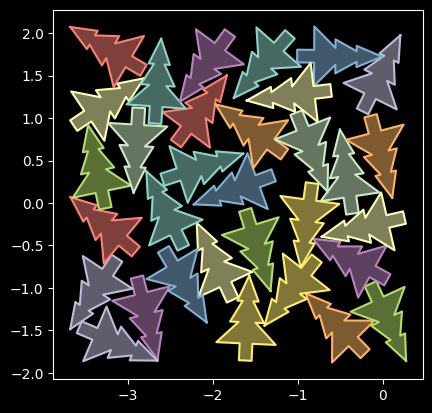

In [6]:
best_score = jax.numpy.array([h.best_score for h in history["global_state"]])
best_feasible_score = jax.numpy.array([h.best_feasible_score for h in history["global_state"]])

plt.semilogy(best_feasible_score, color="tab:blue")
plt.figure()
tree_packing.plot.plot_solution(history["global_state"][-1].best_solution)